# Chicago Housing Model

## Models selected

- Linear regression (benchmark)

- Gradient-boosting decision tree, [LightGBM](https://lightgbm.readthedocs.io/en/latest/index.html)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


In [4]:
fp_dataset = '../datasets/chicago_housing_data.csv'
df = pd.read_csv(fp_dataset)

# target features
target_cols = [
    'Land Square Feet',
    'Building Square Feet',
    'Rooms', 
    'Bedrooms',
    'Full Baths',
    'Garage 1 Size',
    'Garage 2 Size',
    'Age',
    'Population', 
    'EKW_2024', 
    'INC_2019-2023', 
    'CZM_2023', 
    'EDB_2019-2023',
    'Sale Price']

df.drop(df.loc[df['Pure Market Filter'] == 0].index, inplace=True)  # filtering to pure market
df = df[target_cols]

# remove outliers
df = df[(df['Sale Price'] < df['Sale Price'].quantile(0.99))]

garage_map = {
    0: 0,
    1: 1,
    2: 1.5,
    3: 2,
    4: 2.5,
    5: 3,
    6: 3.5,
    7: 0,
    8: 4
}

# converting the column to its actual size values
df['Garage 1 Size'] = df['Garage 1 Size'].astype(int).map(garage_map)
df['Garage 2 Size'] = df['Garage 2 Size'].astype(int).map(garage_map)

print("\nUnique values after mapping:")
print("Garage 1:", df['Garage 1 Size'].unique())
print("Garage 2:", df['Garage 2 Size'].unique())

display(df)



Unique values after mapping:
Garage 1: [2.  1.  0.  2.5 1.5 3.  3.5]
Garage 2: [0.  1.  2.  3.  2.5 1.5]


,Land Square Feet,Building Square Feet,Rooms,Bedrooms,Full Baths,Garage 1 Size,Garage 2 Size,Age,Population,EKW_2024,INC_2019-2023,CZM_2023,EDB_2019-2023,Sale Price
0,4500.0,7435.0,24.0,12.0,6.0,2.0,0.0,87,5101.0,14.13,36681.0,473.0,86.393773,79000
2,7560.0,2538.0,6.0,5.0,2.0,1.0,0.0,62,2928.0,14.89,79896.0,45.0,89.829728,560000
3,4750.0,1673.0,5.0,2.0,2.0,0.0,0.0,74,3831.0,15.83,102094.0,163.0,87.607638,318000
5,4687.0,2090.0,11.0,4.0,2.0,2.0,0.0,92,4693.0,14.79,63523.0,494.0,96.694215,63000
7,6936.0,1384.0,6.0,3.0,1.0,0.0,0.0,58,6116.0,14.89,117583.0,82.0,90.208817,170400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186046,3720.0,1510.0,9.0,5.0,1.0,1.0,0.0,65,5348.0,15.20,122652.0,104.0,94.859813,279500
186047,5406.0,2892.0,9.0,4.0,2.0,0.0,0.0,110,2922.0,15.00,73041.0,141.0,91.180524,1169000
186048,4000.0,1512.0,7.0,4.0,1.0,2.0,0.0,65,5424.0,12.39,43986.0,315.0,86.263591,65000
186050,2750.0,2142.0,10.0,5.0,2.0,0.0,0.0,120,3621.0,13.67,27012.0,227.0,91.807591,77500


In [5]:
x = df.drop(columns=['Sale Price'])
y = df['Sale Price']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
lingres = LinearRegression()
lingres.fit(x_train, y_train)

LinearRegression()

Mean Squared Error: 29962436982.0842
R-squared Score: 0.5828


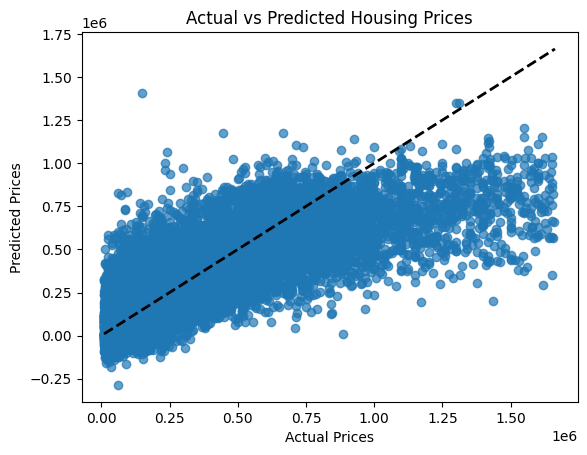

In [6]:
y_pred = lingres.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"R-squared Score: {r2:.4f}")
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2) 
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted Housing Prices")
plt.show()


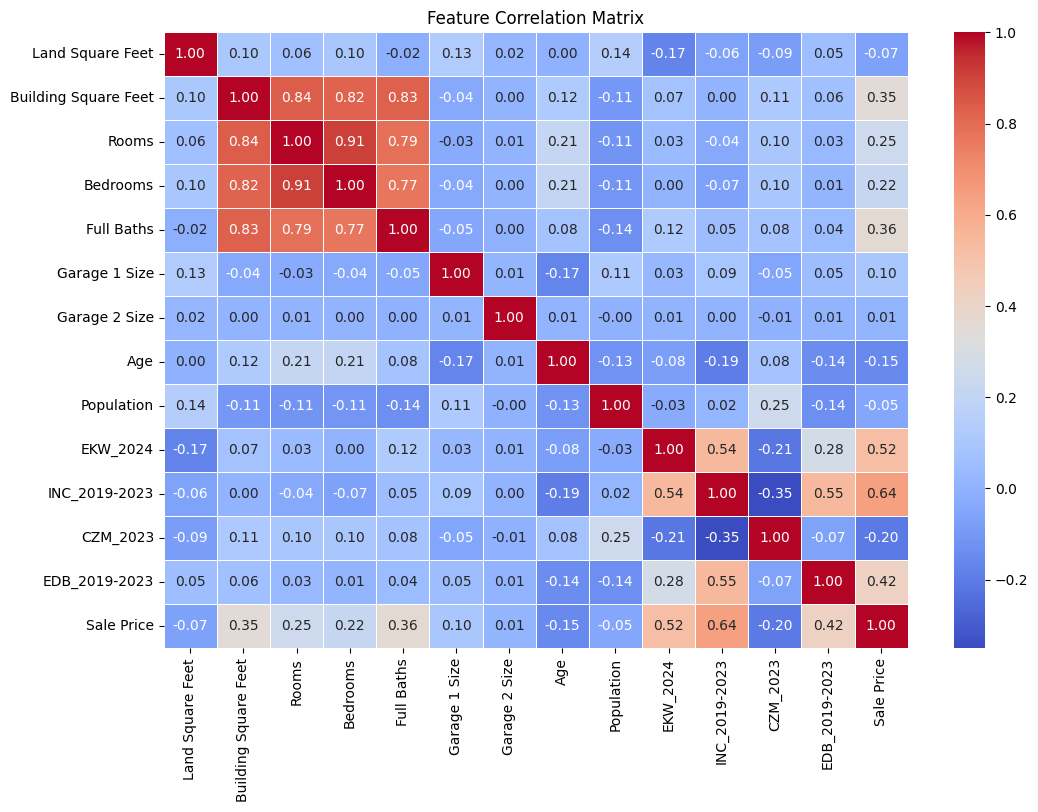

Top correlated features with 'Sale Price':
 Sale Price              1.000000
INC_2019-2023           0.636752
EKW_2024                0.521387
EDB_2019-2023           0.420488
Full Baths              0.361660
Building Square Feet    0.348436
Rooms                   0.250911
Bedrooms                0.216610
CZM_2023                0.203047
Age                     0.152491
Garage 1 Size           0.098648
Land Square Feet        0.066423
Population              0.048876
Garage 2 Size           0.009644
Name: Sale Price, dtype: float64


In [7]:
corr_matrix = df[target_cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()

target_correlation = corr_matrix["Sale Price"].abs().sort_values(ascending=False)
print("Top correlated features with 'Sale Price':\n",target_correlation)


# Perform some fixes

In [8]:
fp_dataset = '../datasets/chicago_housing_data.csv'
df = pd.read_csv(fp_dataset)
df = df[df['Pure Market Filter'] == 1]
df = df[(df['Sale Price'] < df['Sale Price'].quantile(0.99))]

df['log_Land_SQFT'] = np.log1p(df['Land Square Feet'])
df['log_Building_SQFT'] = np.log1p(df['Building Square Feet'])
df['log_INC'] = np.log1p(df['INC_2019-2023'])
df['log_CZM'] = np.log1p(df['CZM_2023'])

# Polynomial terms
df['Age_Squared'] = df['Age'] ** 2
df['EKW_Squared'] = df['EKW_2024'] ** 2  # Walkability

selected_features = [
    # 'log_Land_SQFT',
    'log_Building_SQFT',
    'Rooms',
    'Bedrooms',
    'Full Baths',
    'Garage 1 Size',
    'Garage 2 Size',
    # 'Age',
    'Age_Squared',
    'log_INC',
    'log_CZM',
    'EKW_2024',
    # 'EKW_Squared',
    'EDB_2019-2023',
    'Population',
    'Sale Price'
]

og_df = df
df = df[selected_features]
display(df)


,log_Building_SQFT,Rooms,Bedrooms,Full Baths,Garage 1 Size,Garage 2 Size,Age_Squared,log_INC,log_CZM,EKW_2024,EDB_2019-2023,Population,Sale Price
0,8.914088,24.0,12.0,6.0,3.0,7.0,7569,10.510041,6.161207,14.13,86.393773,5101.0,79000
2,7.839526,6.0,5.0,2.0,1.0,7.0,3844,11.288494,3.828641,14.89,89.829728,2928.0,560000
3,7.422971,5.0,2.0,2.0,0.0,7.0,5476,11.533659,5.099866,15.83,87.607638,3831.0,318000
5,7.645398,11.0,4.0,2.0,3.0,7.0,8464,11.059173,6.204558,14.79,96.694215,4693.0,63000
7,7.233455,6.0,3.0,1.0,0.0,7.0,3364,11.674908,4.418841,14.89,90.208817,6116.0,170400
...,...,...,...,...,...,...,...,...,...,...,...,...,...
186046,7.320527,9.0,5.0,1.0,1.0,7.0,4225,11.717115,4.653960,15.20,94.859813,5348.0,279500
186047,7.970049,9.0,4.0,2.0,0.0,7.0,12100,11.198790,4.955827,15.00,91.180524,2922.0,1169000
186048,7.321850,7.0,4.0,1.0,3.0,7.0,4225,10.691649,5.755742,12.39,86.263591,5424.0,65000
186050,7.669962,10.0,5.0,2.0,0.0,7.0,14400,10.204074,5.429346,13.67,91.807591,3621.0,77500


MSE: 30933019978.34
R²: 0.5693


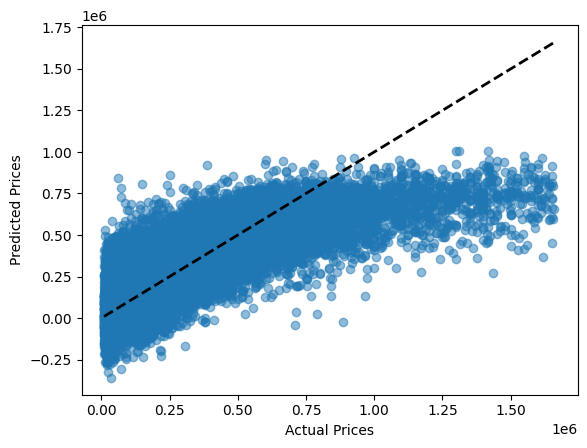

log_Building_SQFT    180043.857960
Rooms                 -1084.572576
Bedrooms             -13845.768040
Full Baths            41517.811824
Garage 1 Size          8549.023796
Garage 2 Size         -2759.185029
Age_Squared              -0.861160
log_INC              225916.183499
log_CZM                 177.793250
EKW_2024              39435.992332
EDB_2019-2023          3041.412019
Population               -3.448465
dtype: float64


In [9]:
# Split data
X = df.drop(columns=['Sale Price'])
y = df['Sale Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

print(f"MSE: {mean_squared_error(y_test, y_pred):.2f}")
print(f"R²: {r2_score(y_test, y_pred):.4f}")

# Plot results
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2) 
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.show()

lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
print(pd.Series(lasso.coef_, index=X.columns))

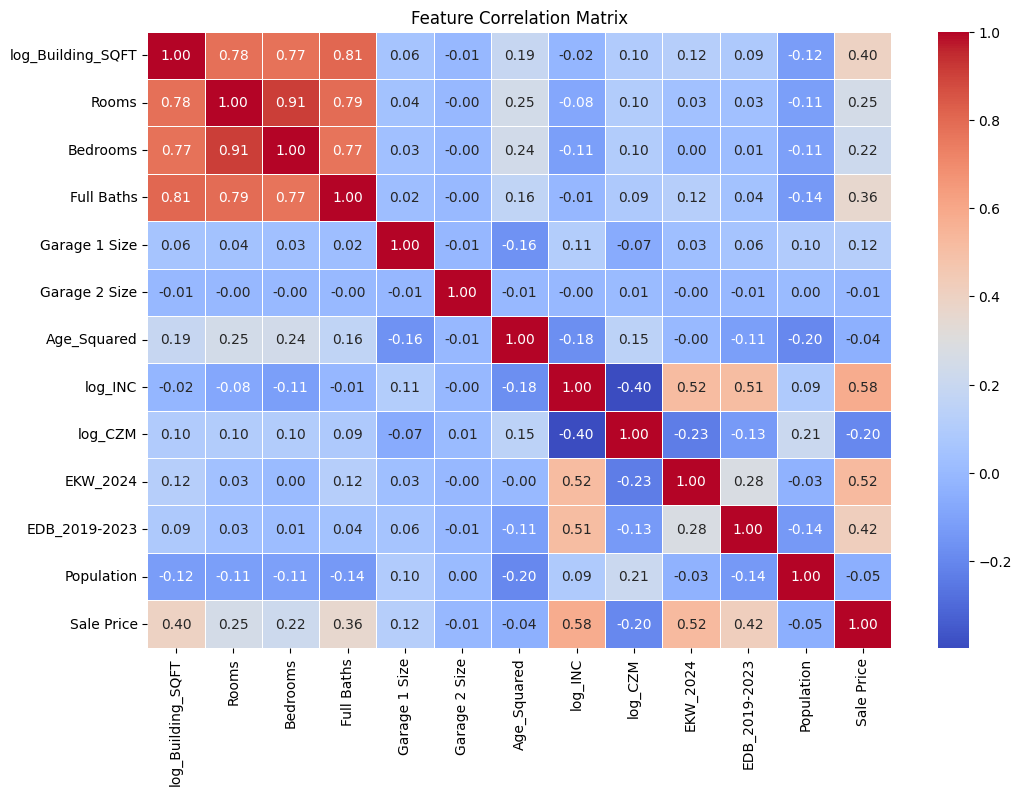

Top correlated features with 'Sale Price':
 Sale Price           1.000000
log_INC              0.582770
EKW_2024             0.521387
EDB_2019-2023        0.420488
log_Building_SQFT    0.399053
Full Baths           0.361660
Rooms                0.250911
Bedrooms             0.216610
log_CZM              0.199340
Garage 1 Size        0.116555
Population           0.048876
Age_Squared          0.043910
Garage 2 Size        0.007406
Name: Sale Price, dtype: float64


In [10]:
corr_matrix = og_df[selected_features].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()

target_correlation = corr_matrix["Sale Price"].abs().sort_values(ascending=False)
print("Top correlated features with 'Sale Price':\n",target_correlation)
